In [3]:
import xarray as xr
import cfgrib
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd


In [4]:
grib_data = cfgrib.open_datasets('../../data2022.grib')
surface = grib_data[0] 
hybrid = grib_data[1] 

In [5]:
feature_list = ['t2m', 'tcc', 'u10', 'v10', 'tp', 'sp']
t2m = surface.t2m.to_numpy() - 273.15  # -> C
sp = surface.sp.to_numpy() / 100       # -> hPa
tcc = surface.tcc.to_numpy()
u10 = surface.u10.to_numpy()
v10 = surface.v10.to_numpy()
tp = hybrid.tp.to_numpy().reshape((-1,) + hybrid.tp.shape[2:])
data = np.stack((t2m, tcc, u10, v10, tp, sp), axis=-1)

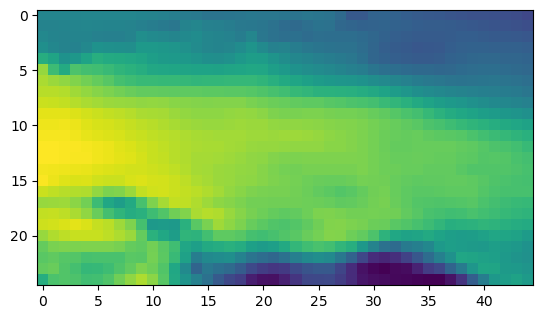

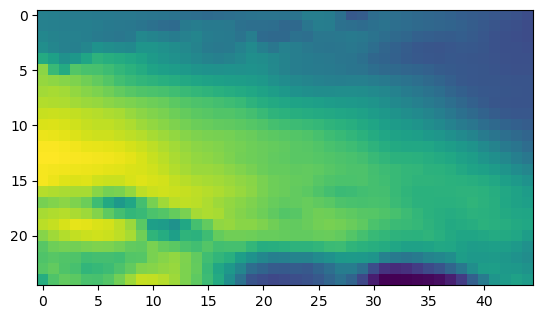

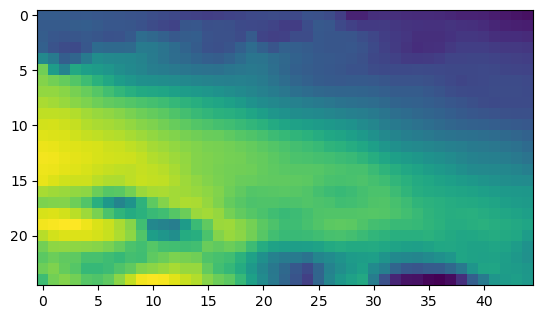

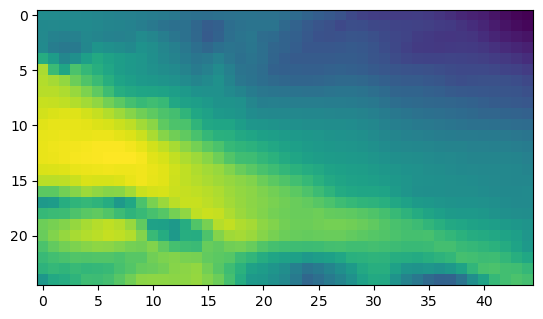

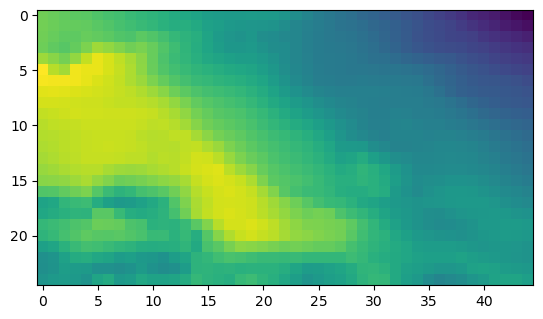

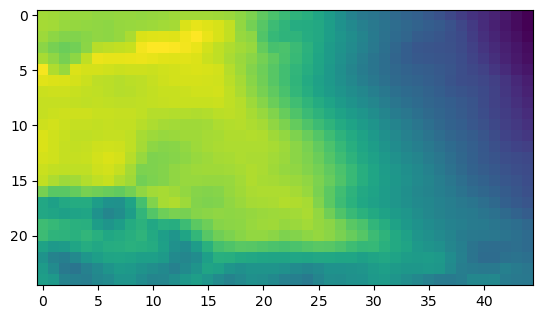

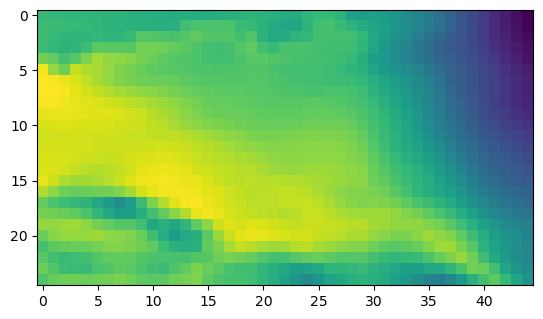

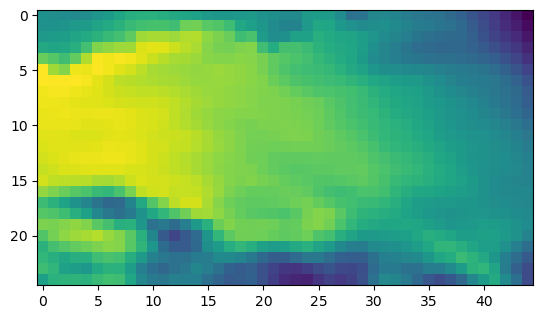

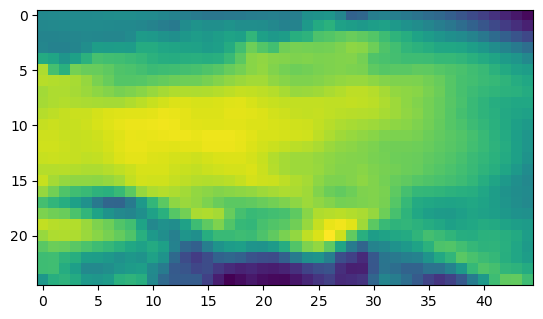

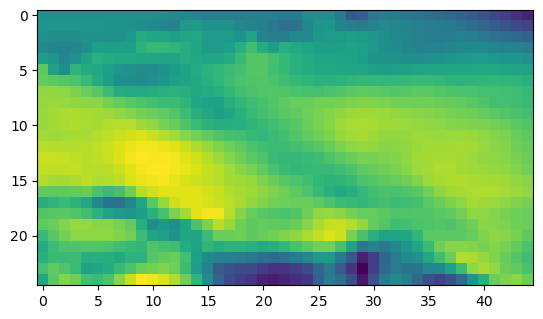

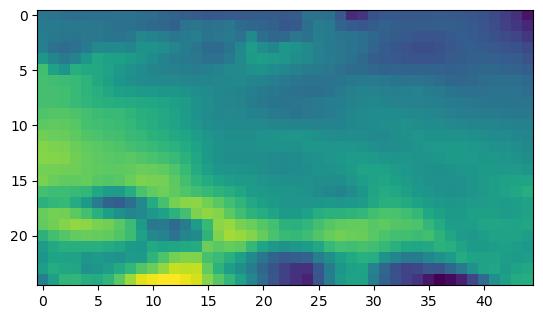

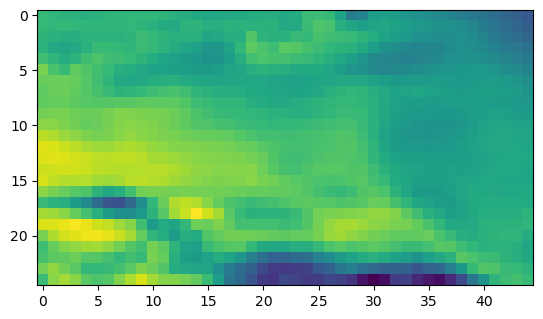

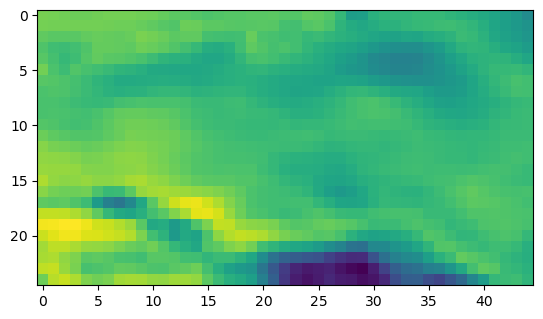

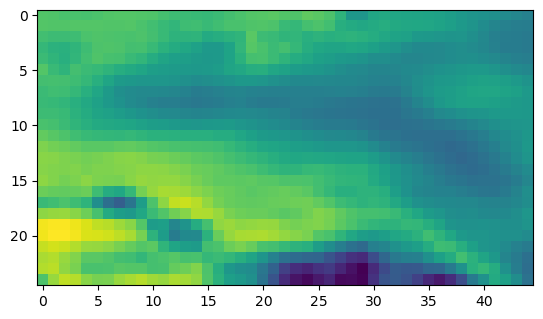

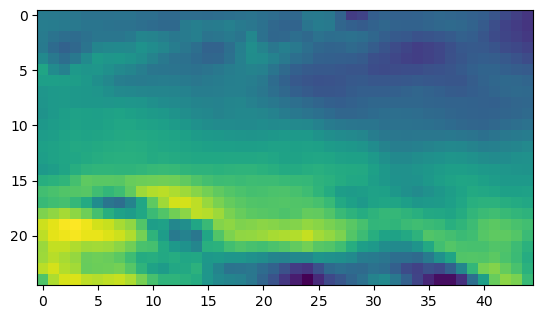

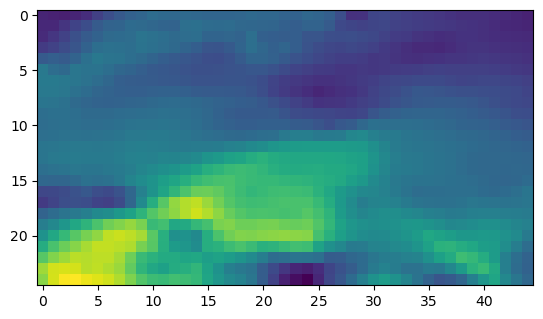

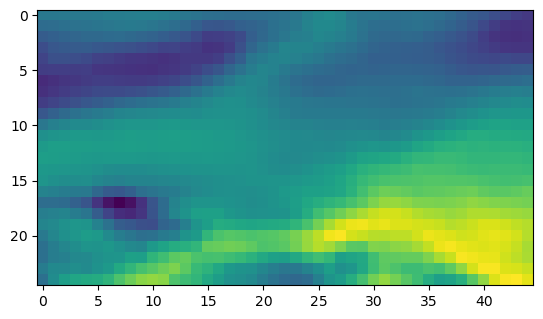

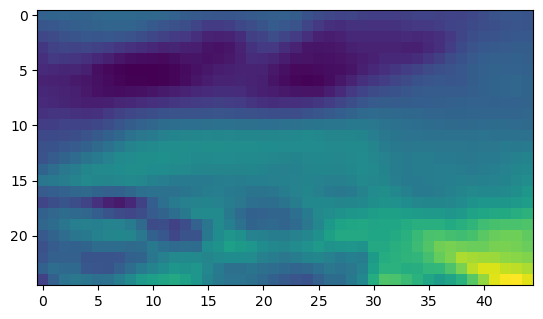

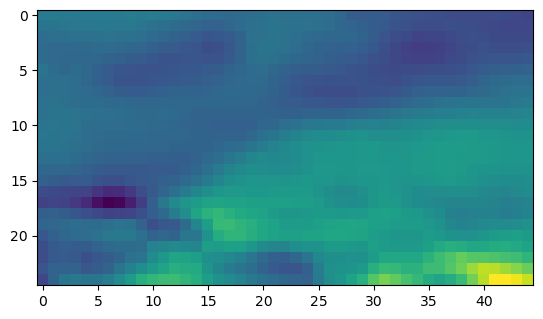

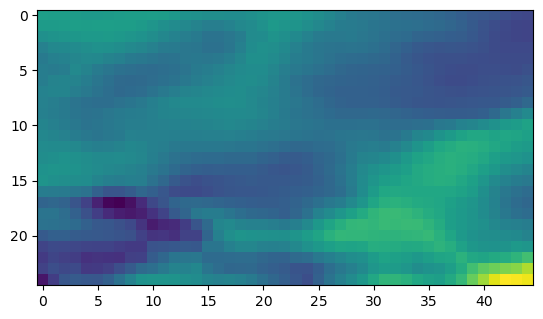

In [6]:

for i in range(20):
    plt.imshow(t2m[i])
    plt.show()

In [7]:
surface

<xarray.Dataset>
Dimensions:     (time: 1432, latitude: 25, longitude: 45)
Coordinates:
    number      int64 0
  * time        (time) datetime64[ns] 2022-01-01 ... 2022-12-30T18:00:00
    step        timedelta64[ns] 00:00:00
    surface     float64 0.0
  * latitude    (latitude) float64 55.0 54.75 54.5 54.25 ... 49.5 49.25 49.0
  * longitude   (longitude) float64 14.0 14.25 14.5 14.75 ... 24.5 24.75 25.0
    valid_time  (time) datetime64[ns] 2022-01-01 ... 2022-12-30T18:00:00
Data variables:
    sp          (time, latitude, longitude) float32 1.012e+05 ... 9.845e+04
    tcc         (time, latitude, longitude) float32 1.0 1.0 ... 0.4218 0.3764
    u10         (time, latitude, longitude) float32 8.384 8.398 ... 1.03 1.073
    v10         (time, latitude, longitude) float32 0.453 0.2928 ... -1.615
    t2m         (time, latitude, longitude) float32 279.3 279.3 ... 280.4 280.1
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

In [8]:
t2m = surface.t2m.to_numpy()
t2m.shape

(1432, 25, 45)

In [9]:
hybrid

<xarray.Dataset>
Dimensions:     (time: 716, step: 2, latitude: 25, longitude: 45)
Coordinates:
    number      int64 0
  * time        (time) datetime64[ns] 2021-12-31T18:00:00 ... 2022-12-30T06:0...
  * step        (step) timedelta64[ns] 06:00:00 12:00:00
    surface     float64 0.0
  * latitude    (latitude) float64 55.0 54.75 54.5 54.25 ... 49.5 49.25 49.0
  * longitude   (longitude) float64 14.0 14.25 14.5 14.75 ... 24.5 24.75 25.0
    valid_time  (time, step) datetime64[ns] ...
Data variables:
    tp          (time, step, latitude, longitude) float32 3.052e-05 ... 3.29e-05
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

In [10]:
def step_split(feature, n_steps=3):
    step_split = np.split(feature, n_steps, axis=1)
    step_split = [np.squeeze(arr, axis=1) for arr in step_split]

    return np.array(step_split)

In [11]:
#convert tigge into usable format

grib_file = '../../2022-01-01-to-2022-12-31.grib'
grib_data = cfgrib.open_datasets(grib_file)


first_step = int(grib_data[0].step[2])

tcc_tigge = grib_data[0].tcc.to_numpy()

tcc_step_0, tcc_step_6, tcc_step_12 = step_split(tcc_tigge)

u10_tigge = grib_data[1].u10.to_numpy()

u10_step_0, u10_step_6, u10_step_12 = step_split(u10_tigge)

v10_tigge = grib_data[1].v10.to_numpy()

v10_step_0, v10_step_6, v10_step_12 = step_split(v10_tigge)

t2m_tigge = grib_data[2].t2m.to_numpy()

t2m_step_0, t2m_step_6, t2m_step_12 = step_split(t2m_tigge) - 273.15

sp_tigge = grib_data[3].sp.to_numpy()

sp_step_0, sp_step_6, sp_step_12 = step_split(sp_tigge) / 100

tp_tigge = grib_data[3].tp.to_numpy()

tp_step_0, tp_step_6, tp_step_12 = step_split(tp_tigge)



data_step_0 = np.stack((t2m_step_0, tcc_step_0, u10_step_0, v10_step_0, tp_step_0, sp_step_0), axis=-1)

data_step_6 = np.stack((t2m_step_6, tcc_step_6, u10_step_6, v10_step_6, tp_step_6, sp_step_6), axis=-1)

data_step_12 = np.stack((t2m_step_12, tcc_step_12, u10_step_12, v10_step_12, tp_step_12, sp_step_12), axis=-1)



In [12]:
data_step_6.shape

(730, 25, 45, 6)